# Attention

## RNN recap

In a basic RNN, each recurrent neuron receives inputs from all neurons from the previous time step, as well as the inputs from the current time step, hence the term 'recurrent'.

In [174]:
### This cell should be hidden in the final version

import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.src.utils import pad_sequences
from jupyterquiz import display_quiz
from sklearn.metrics import accuracy_score
from keras.datasets import imdb


git_path="https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Quizes/"

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)

max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test = pad_sequences(x_test, maxlen=max_len, truncating='post')
num_words = 10000

embedding_dim = 100
hidden_dim = 256
output_dim = 1
dropout_rate = 0.5


# model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len),
#    tf.keras.layers.SimpleRNN(hidden_dim),
#    tf.keras.layers.Dense(output_dim, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model is loaded from the file to save time

simpleRNN = tf.keras.models.load_model('simpleRNN.keras')

# make predictions and calculate accuracy

y_pred = simpleRNN.predict(x_test)
y_pred = np.round(y_pred)

simple_accuracy = accuracy_score(y_test, y_pred)


782/782 [==============================] - 16s 21ms/step


In [175]:
display_quiz(git_path + 'quiz_rnn.json')

<IPython.core.display.Javascript object>

When applying RNNs to IMDB reviews, we get the following accuracy graph over 50 epochs:

In [176]:
import plotly.graph_objects as go
from ipywidgets import interactive, IntSlider
from IPython.display import display

epochs = np.arange(1, 51)  # 1 to 50 epochs
accuracy_epochs = pd.read_csv('simplernn_accuracy.csv')

def plot_accuracy(epoch):
    # Create a plot up to the specified epoch
    fig = go.Figure(data=go.Scatter(x=accuracy_epochs['epoch'][:epoch], y=accuracy_epochs['accuracy'][:epoch], mode='lines+markers'))
    fig.add_annotation(x=epoch, y=accuracy_epochs['accuracy'][49],
                       text=f"Final Accuracy: {accuracy_epochs['accuracy'][49]:.2f}",
                       showarrow=True,
                       arrowhead=1,
                       ax=20,
                       ay=-40)
    fig.update_layout(title='RNN Accuracy Over Epochs',
                      xaxis_title='Epochs',
                      yaxis_title='Accuracy')
    fig.show()

# Create a slider for selecting epochs
epoch_slider = IntSlider(min=1, max=50, step=1, value=10, description='Epochs')

# Create the interactive plot
interactive_plot = interactive(plot_accuracy, epoch=epoch_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=10, description='Epochs', max=50, min=1), Output()), _dom_classes=('widg…

However, we can see that the accuracy of the model does not improve much after the first few epochs. This forces us to use a large number of epochs to get a good accuracy, which is not ideal, and even then, the accuracy may not improve by much

## The Need for Attention Mechanism
::::{important}
The problem with basic RNNs is that they are not very good at handling long sequences. 

Even when using more epochs, the accuracy of the model does not improve much. This is because the model is not able to learn the long-term dependencies in the data.

This is known as the vanishing gradient problem.
::::

### Vanishing Gradient Problem

The vanishing gradient problem occurs when the gradients of the loss function become increasingly smaller as the model learns to associate inputs and outputs that are further apart in time.

This leads to the model "forgetting" the information from the earlier inputs, which makes it difficult to learn long-term dependencies.

![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNN.png)

### Math Behind Vanishing Gradient Problem

The vanishing gradient problem occurs because of the way gradients are computed in RNNs:

::::{note}
$$
\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial h} \frac{\partial h}{\partial W}
$$
::::

The gradient is computed by multiplying the gradients of the loss function with respect to the output, the output with respect to the hidden state, and the hidden state with respect to the weights.

::::{important}
Since gradients are multiplied together, if the gradients at each time step are less than 1 (e.g., due to using activation functions like sigmoid or tanh), this multiplication leads to a compounding effect. As you go further back in time, the gradients become increasingly smaller.
::::

![Simple RNN](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/SimpleRNNProblem.png)

In [177]:
display_quiz(git_path + 'quiz_vanish.json')

<IPython.core.display.Javascript object>

## Attention Mechanism

To combat the vanishing gradient problem, we can use an attention mechanism.

::::{important}
An attention mechanism is a way to help RNNs learn long-term dependencies by allowing the model to focus on the most relevant parts of the input sequence when producing a given output.
::::

We do this by adding a context vector to the model, which is a weighted sum of the encoder's hidden states. The weights are computed using an alignment score function, which measures how well the inputs around a given position and the output at that position match.

![Attention Mechanism](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/Attention.png)

In [178]:
from keras.layers import Input, Embedding, LSTM, Dense, Attention, Bidirectional, Dropout, SimpleRNN
import os

inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len)(inputs)
rnn = SimpleRNN(hidden_dim, return_sequences=True)(embedding)
attention = Attention()([rnn, rnn])
context = tf.reduce_sum(attention * rnn, axis=1)
outputs = Dense(output_dim, activation='sigmoid')(context)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# load the model

model = tf.keras.models.load_model('simpleRNN_attention.keras')

In [179]:
import plotly.graph_objects as go
from ipywidgets import interactive, Dropdown, Output, Layout

# Function to create Simple RNN plot
def create_simple_rnn_plot():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[1, 2, 3], y=[1, 1, 1], mode='markers+text',
                             text=['Input', 'Hidden State', 'Output'],
                             marker=dict(size=20, color='LightSkyBlue')))
    # ... Add connections and other details ...
    return fig

# Function to create RNN with Attention plot
def create_rnn_attention_plot():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[1, 2, 3, 4], y=[1, 1, 1, 1], mode='markers+text',
                             text=['Input', 'Hidden State', 'Attention', 'Output'],
                             marker=dict(size=20, color='LightSkyBlue')))
    # ... Add connections and other details ...
    return fig

# Dropdown for model selection
dropdown = Dropdown(
    options=[('Simple RNN', 'simple_rnn'), ('RNN with Attention', 'rnn_attention')],
    value='simple_rnn',
    description='Model:',
    layout=Layout(height='20px')
)

# Container for the plot
plot_container = Output()

def on_dropdown_change(change):
    if change['new'] == 'simple_rnn':
        fig = create_simple_rnn_plot()
    else:
        fig = create_rnn_attention_plot()

    with plot_container:
        plot_container.clear_output(wait=True)
        display(fig)

# Observe dropdown change
dropdown.observe(on_dropdown_change, names='value')

# Initial plot
on_dropdown_change({'new': 'simple_rnn'})

# Display UI
display(dropdown)
display(plot_container)


Dropdown(description='Model:', layout=Layout(height='20px'), options=(('Simple RNN', 'simple_rnn'), ('RNN with…

Output()

## Math Behind Attention Mechanism

::::{note}
The context vector is computed as follows:

$$
c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j
$$

where $c_i$ is the context vector at position $i$, $T_x$ is the length of the input sequence, $\alpha_{ij}$ is the alignment score between the output at position $i$ and the input at position $j$, and $h_j$ is the hidden state at position $j$.
::::

![Attention Mechanism](https://raw.githubusercontent.com/ChaosTheLegend/ML-Book/main/Images/AttentionLive.png)

| a_1  | a_2 | a_3 | a_4 | sum |
|------|-----|-----|-----|-----|
| 0.1  | 0.2 | 0.3 | 0.4 | 1.0 |
| 0.5, | 0.6 | 0.7 | 0.8 | 2.6 |
| 0.9  | 0.1 | 0.2 | 0.3 | 1.5 |
| 0.4  | 0.3 | 0.6 | 0.7 | 2.0 |

| h_1 | h_2 | h_3 | h_4 |
|-----|-----|-----|-----|
| 0.9 | 0.5 | 0.2 | 0.1 |


In [180]:
display_quiz(git_path + 'quiz_scores.json')

<IPython.core.display.Javascript object>

## Alignment Scores

::::{important}
The alignment scores are computed using a score function, which measures how well the inputs around a given position and the output at that position match.
::::

There are many different score functions that can be used, but the most common one is the dot product:

::::{note}
$$
score(h_i, h_j) = h_i^T h_j
$$
::::

where $h_i$ is the hidden state at position $i$ and $h_j$ is the hidden state at position $j$.

The alignment scores are then computed as follows:

::::{note}
$$
\alpha_{ij} = \frac{exp(score(h_i, h_j))}{\sum_{k=1}^{T_x} exp(score(h_i, h_k))}
$$
::::

where $T_x$ is the length of the input sequence.

::::{note}
The resulting matrix of alignment scores will look like this:

$$
\begin{bmatrix}
\alpha_{11} & \alpha_{12} & \alpha_{13} & \dots & \alpha_{1T_x} \\
\alpha_{21} & \alpha_{22} & \alpha_{23} & \dots & \alpha_{2T_x} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\alpha_{T_y1} & \alpha_{T_y2} & \alpha_{T_y3} & \dots & \alpha_{T_yT_x} \\
\end{bmatrix}
$$
::::

In the beginning, the alignment scores are random, but as the model learns using backpropagation, the alignment scores are updated to reflect how well the inputs around a given position and the output at that position match.

::::{note}
$$
new\_alignment\_scores = old\_alignment\_scores + \frac{\partial L}{\partial \alpha_{ij}}
$$
::::

The following graph shows the sum of alignment scores after training the model for 5 epochs:

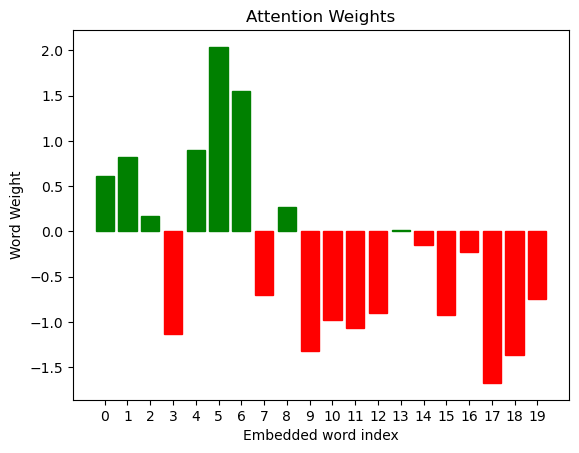

In [181]:
attention_layer = model.layers[2]

weights = attention_layer.get_weights()[1]

# sum all the columns in the weights matrix

weights = np.sum(weights, axis=1)

weights = weights[:20]

plt.bar(range(weights.shape[0]), weights)

plt.title('Attention Weights')

plt.xlabel('Embedded word index')

plt.ylabel('Word Weight')

# make x axis use whole numbers

plt.xticks(range(weights.shape[0]), range(weights.shape[0]))

# color all negative weight bars red and positive weights blue

for i in range(weights.shape[0]):
    if weights[i] < 0:
        plt.gca().get_children()[i].set_color('red')
    else:
        plt.gca().get_children()[i].set_color('green')

plt.show()

::::{note}
The Lower the absolute value of the weight, the less relevant the word is to the output

Green bars show positive weights, indicating that the word is positive

Red bars show negative weights, indicating that the word is negative
::::

The computed vector is then multiplied by the hidden state at position $i$ to produce the output at position $i$, this is being done in the context layer. In the case of Binary Classification, we use dense layer with sigmoid activation function to produce the output.

::::{note}
$$
sum =  \sum_{i=1}^{T_x} \alpha_{ij} h_j
$$

$$
output = \sigma(sum)
$$
::::

But attention can also be used for other tasks such as Machine Translation, where another RNN is used to decode the output sequence.
(See Transformers)

In [182]:
display_quiz(git_path + 'quiz_att.json')

<IPython.core.display.Javascript object>

## Using Attention Mechanism

By adding an attention mechanism, our model performs way better even when using the low number of epochs.

In [183]:
# draw a bar chart to compare the accuracy of the two models

y_pred = model.predict(x_test)

y_pred = np.round(y_pred)

attention_accuracy = accuracy_score(y_test, y_pred)

# draw a bar chart to compare the accuracy of the two models
import plotly.graph_objects as go
fig = go.Figure(data =[
    go.Bar(name="Attention Model", x=['Accuracy'], y=[attention_accuracy]),
    go.Bar(name='Simple RNN', x=['Accuracy'], y=[simple_accuracy])
])

fig.update_layout(barmode='group', title='Model Performance Comparison',
                  yaxis_title='Accuracy', xaxis_title='Model')
fig.show()



782/782 [==============================] - 28s 36ms/step


::::{note}

Attention Mechanism can also be used with other RNN implementations such as LSTM and GRU.

It can also be used with Bidirectional RNNs, and even with CNNs.

Here's an example of using Attention Mechanism with Bidirectional LSTM:

::::

In [ ]:
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len)(inputs)
lstm = Bidirectional(LSTM(hidden_dim, return_sequences=True))(embedding)
attention = Attention()([lstm, lstm])
context = tf.reduce_sum(attention * lstm, axis=1)
dropout = Dropout(dropout_rate)(context)
output = Dense(output_dim, activation='sigmoid')(dropout)
model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM = tf.keras.models.load_model('LSTM.keras')

y_pred = LSTM.predict(x_test)

y_pred = np.round(y_pred)

lstm_accuracy = accuracy_score(y_test, y_pred)

accuracy = [attention_accuracy, lstm_accuracy, simple_accuracy]

plt.bar(['Attention (5 epochs)', 'LSTM (5 epochs)', 'Simple RNN (50 epochs)'], accuracy)

plt.title('Accuracy of Different RNNs')

plt.ylabel('Accuracy')

311/782 [==========>...................] - ETA: 1:14

## Summary

::::{important}
Attention Mechanism is a way to help RNNs learn long-term dependencies by allowing the model to focus on the most relevant parts of the input sequence when producing a given output.
::::

::::{important}
It does this by adding a context vector to the model, which is a weighted sum of the encoder's hidden states. The weights are computed using an alignment score function, which measures how well the inputs around a given position and the output at that position match.
::::